In [1]:
### https://anaconda.org/anaconda/py-xgboost
### Importando as libs
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
import pylab as pl
from sklearn import model_selection
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

# Scripts

In [2]:
def seedAnalytcs(train,colunas,colunasy,teste_size):
    for seed_it in  range(1,15):
        print('SEED=',seed_it)
        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed_it)
        x =x_treino.sort_values(by=['SaudacaoNum'])['SaudacaoNum'].unique()
        y=x_teste.sort_values(by=['SaudacaoNum'])['SaudacaoNum'].unique()
        print(x)
        print(y )
        print(y in x)

In [3]:
class Titanic:
    score=0
    colunas_final=[]
    max_depth_final=0
    seed_final=0
    acertos_final=0
    erros_final=0
    min_child_weight_final=0
    actuals=0
    predictions=0

In [4]:
def forward_feature_construction(colunasx,colunasy):
    size = len(colunasx)
    lista = list()
    for id in  range(1,size):
        for x in  combinations(colunasx,r=id):
            lista.append(list(x))
    return lista    

In [5]:
def print_titanic(resultado):
    print('#####################################################')
    print('################# RESULTADOS ########################')
    print('#####################################################')
    for titanic in resultado:
        print_titanic_valores(titanic)

In [6]:
def print_titanic_valores(titanic):
    print('Score =',titanic.score)
    print('acertos=',titanic.acertos_final)
    print('erros=',titanic.erros_final)
    print('colunas=',titanic.colunas_final)
    print('seed=',titanic.seed_final)
    print('max_depth_final=',titanic.max_depth_final)
    print('min_child_weight_final=',titanic.min_child_weight_final)
    print(confusion_matrix(titanic.actuals, titanic.predictions))
    print('#####################################################')

In [7]:
def predict(lista, train, colunasy,teste_size,scan):
   
    ### Config Default
    colunasx_it=['Classe','FamiliaQtde','PassagemPreco','SexoNum','SaudacaoNum']
    seed = 9
    max_depth=3
    min_child_weight=1
    
    ### Inicializando variáveis
    seed_it = seed
    max_depth_it=max_depth
    min_child_weight_it=min_child_weight
    colunasx_it=colunasx_it
    ultimo_acerto=0
    
    ### Config Final
    resultado = []
          
    if scan:
        for colunasx_it in  lista:
            ### Slice
            x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunasx_it],train[colunasy],test_size=teste_size,random_state=seed_it)
            ### Modelo - Treino
            xgb_model = xgb.XGBClassifier(max_depth=max_depth_it,min_child_weight=min_child_weight_it).fit(x_treino, y_treino)
            ### Modelo - Predict
            predictions = xgb_model.predict(x_teste)
            ### Confusion Matrix
            actuals = y_teste
            #print(colunasx)
            previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
            resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
            resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
            pontuacao=(xgb_model.score(x_teste,y_teste)*100.0)

            if resultadoAcertos.size >= ultimo_acerto and pontuacao >84 :
                if(resultadoAcertos.size>ultimo_acerto):
                    resultado=[]
                titanic = Titanic()
                ### Score
                titanic.score = pontuacao
                ### Resultado Final
                titanic.max_depth_final=max_depth_it
                titanic.seed_final=seed_it
                titanic.colunas_final=colunasx_it
                titanic.acertos_final=resultadoAcertos.size
                titanic.erros_final=resultadoErros.size
                titanic.min_child_weight_final=min_child_weight
                titanic.actuals=actuals
                titanic.predictions=predictions
                
                resultado.append(titanic)
                ultimo_acerto=resultadoAcertos.size
                
                

    else:
        ### Slice
        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)
        ### Modelo - Treino
        xgb_model = xgb.XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight).fit(x_treino, y_treino)
        ### Modelo - Predict
        predictions = xgb_model.predict(x_teste)
        ### Score
        score = xgb_model.score(x_teste,y_teste)
        actuals = y_teste
        previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
        resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
        resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
        ### Resultado Final
        max_depth_final=max_depth
        seed_final=seed
        colunas_final=colunas
        acertos_final=resultadoAcertos.size
        min_child_weight_final=min_child_weight
    print_titanic(resultado)
    return resultado


    

In [8]:
def predictTitanic(lista,train,colunasy,teste_size):
    
    modelo=0
    ultimo_acerto=0
    max_depth=3
    min_child_weight=1
    titanicResultado = Titanic()
    seed = 9
    
    seed_it = seed
    max_depth_it=max_depth
    min_child_weight_it=min_child_weight
    for titanic in lista:
        for seed_it in  range(9,9):
            for min_child_weight_it in  range(1,10):
                for max_depth_it in  range(0,15):
                    modelo+=1
                    x_treino, x_teste, y_treino, y_teste=model_selection.train_test_split(train[titanic.colunas_final],train[colunasy],test_size=teste_size,random_state=seed_it)
                    xgb_model = xgb.XGBClassifier(max_depth=max_depth_it,min_child_weight=min_child_weight_it,
                                                  n_estimators=1000,n_jobs=4, subsample=0.8, colsample_bytree=0.8).fit(x_treino, y_treino)
                    y_pred = xgb_model.predict(test_csv[titanic.colunas_final])
                    ### Modelo - Predict
                    predictions = xgb_model.predict(x_teste)
                    ### Confusion Matrix
                    actuals = y_teste
                    previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
                    resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
                    resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
                    pontuacao=(xgb_model.score(x_teste,y_teste)*100.0)
                    if resultadoAcertos.size >= ultimo_acerto and pontuacao >85 :
                        titanicResultado = Titanic()
                        ### Score
                        titanicResultado.score = pontuacao
                        ### Resultado Final
                        titanicResultado.max_depth_final=max_depth_it
                        titanicResultado.seed_final=seed_it
                        titanicResultado.colunas_final=titanic.colunas_final
                        titanicResultado.acertos_final=resultadoAcertos.size
                        titanicResultado.erros_final=resultadoErros.size
                        titanicResultado.min_child_weight_final=min_child_weight
                        titanicResultado.actuals=actuals
                        titanicResultado.predictions=predictions
                        ultimo_acerto=resultadoAcertos.size
                        print_titanic_valores(titanicResultado) 

# Coleta de dados

## Fontes

In [9]:
### Coletando as fontes de dados
test_csv = pd.read_csv('r_teste.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_csv = pd.read_csv('r_treino.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_dropna_csv = pd.read_csv('r_treino_dropna.csv', sep = ',', encoding = 'UTF-8',header='infer')

In [10]:
colunasx=[
    'Classe',
    #'FaixaEtaria',
    #'PortoEmbarqueNum',
    #'ParentesIrmao',
    #'ParentesFilhos',
    'SexoNum',
    'SaudacaoNum',
    'PassagemPreco',
    'FamiliaQtde',
    'EstaSozinho',
    #'TemCabine'
]
colunasy=['Sobreviventes']

In [11]:
colunas = forward_feature_construction(colunasx,colunasy)

In [12]:
train= train_dropna_csv
#train= train_csv
train=train.set_index(train['PassageiroId'])

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 14 columns):
PassageiroId        714 non-null int64
Idade               714 non-null float64
FaixaEtaria         714 non-null float64
Classe              714 non-null int64
PortoEmbarqueNum    714 non-null int64
ParentesIrmao       714 non-null int64
ParentesFilhos      714 non-null int64
SexoNum             714 non-null int64
SaudacaoNum         714 non-null int64
PassagemPreco       714 non-null float64
FamiliaQtde         714 non-null int64
EstaSozinho         714 non-null float64
TemCabine           714 non-null float64
Sobreviventes       714 non-null int64
dtypes: float64(5), int64(9)
memory usage: 83.7 KB


In [14]:
### Config
teste_size=0.30 ##30%

In [15]:
resultado=predict(colunas, train, colunasy,teste_size,True)
#84.18604651162791

#####################################################
################# RESULTADOS ########################
#####################################################
Score = 84.18604651162791
acertos= 181
erros= 34
colunas= ['SaudacaoNum', 'PassagemPreco', 'FamiliaQtde']
seed= 9
max_depth_final= 3
min_child_weight_final= 1
[[116  13]
 [ 21  65]]
#####################################################
Score = 84.18604651162791
acertos= 181
erros= 34
colunas= ['SaudacaoNum', 'PassagemPreco', 'FamiliaQtde', 'EstaSozinho']
seed= 9
max_depth_final= 3
min_child_weight_final= 1
[[116  13]
 [ 21  65]]
#####################################################
Score = 84.18604651162791
acertos= 181
erros= 34
colunas= ['Classe', 'SexoNum', 'SaudacaoNum', 'PassagemPreco', 'FamiliaQtde']
seed= 9
max_depth_final= 3
min_child_weight_final= 1
[[120   9]
 [ 25  61]]
#####################################################


# Tuning

In [16]:
predictTitanic(resultado,train,colunasy,teste_size)

# Relatório Kaggle

## Configuração

In [17]:
colunas= ['SaudacaoNum', 'PassagemPreco', 'FamiliaQtde', 'EstaSozinho']
seed= 9
max_depth_final= 3
min_child_weight_final= 1

## Slice

In [18]:
x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)

## Modelo

In [19]:
xgb_model = xgb.XGBClassifier(max_depth=max_depth_final,min_child_weight=min_child_weight_final).fit(x_treino, y_treino)

## Configurações do Modelo

In [20]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
predictions = xgb_model.predict(x_teste)

In [22]:
actuals = y_teste
previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
print(xgb_model.score(x_teste,y_teste)*100.0)

84.18604651162791


In [27]:
listResultadoErros = train.loc[(train.PassageiroId[resultadoErros.index])]
listResultadoErros.sort_values(by=['FaixaEtaria', 'Idade'])

,PassageiroId,Idade,FaixaEtaria,Classe,PortoEmbarqueNum,ParentesIrmao,ParentesFilhos,SexoNum,SaudacaoNum,PassagemPreco,FamiliaQtde,EstaSozinho,TemCabine,Sobreviventes
PassageiroId,,,,,,,,,,,,,,
262,262,3.0,2.0,3,1,4,2,1,3,31.3875,6,0.0,0.0,1
115,115,17.0,5.0,3,2,0,0,0,2,14.4583,0,1.0,0.0,0
69,69,17.0,5.0,3,1,4,2,0,2,7.9250,6,0.0,0.0,1
703,703,18.0,5.0,3,2,0,1,0,2,14.4542,1,0.0,0.0,0
655,655,18.0,5.0,3,3,0,0,0,2,6.7500,0,1.0,0.0,0
284,284,19.0,5.0,3,1,0,0,1,0,8.0500,0,1.0,0.0,1
749,749,19.0,5.0,1,1,1,0,1,0,53.1000,1,0.0,1.0,0
392,392,21.0,6.0,3,1,0,0,1,0,7.7958,0,1.0,0.0,1
883,883,22.0,6.0,3,1,0,0,0,2,10.5167,0,1.0,0.0,0


## Previsões Final

In [24]:
y_test = xgb_model.predict(test_csv[colunas])

## Gerando CSV

In [25]:
submission = pd.DataFrame({
        "PassengerId": test_csv["PassageiroId"],
        "Survived": y_test
    })
submission.to_csv('resultado.csv', index=False)

## Árvore de Decisão

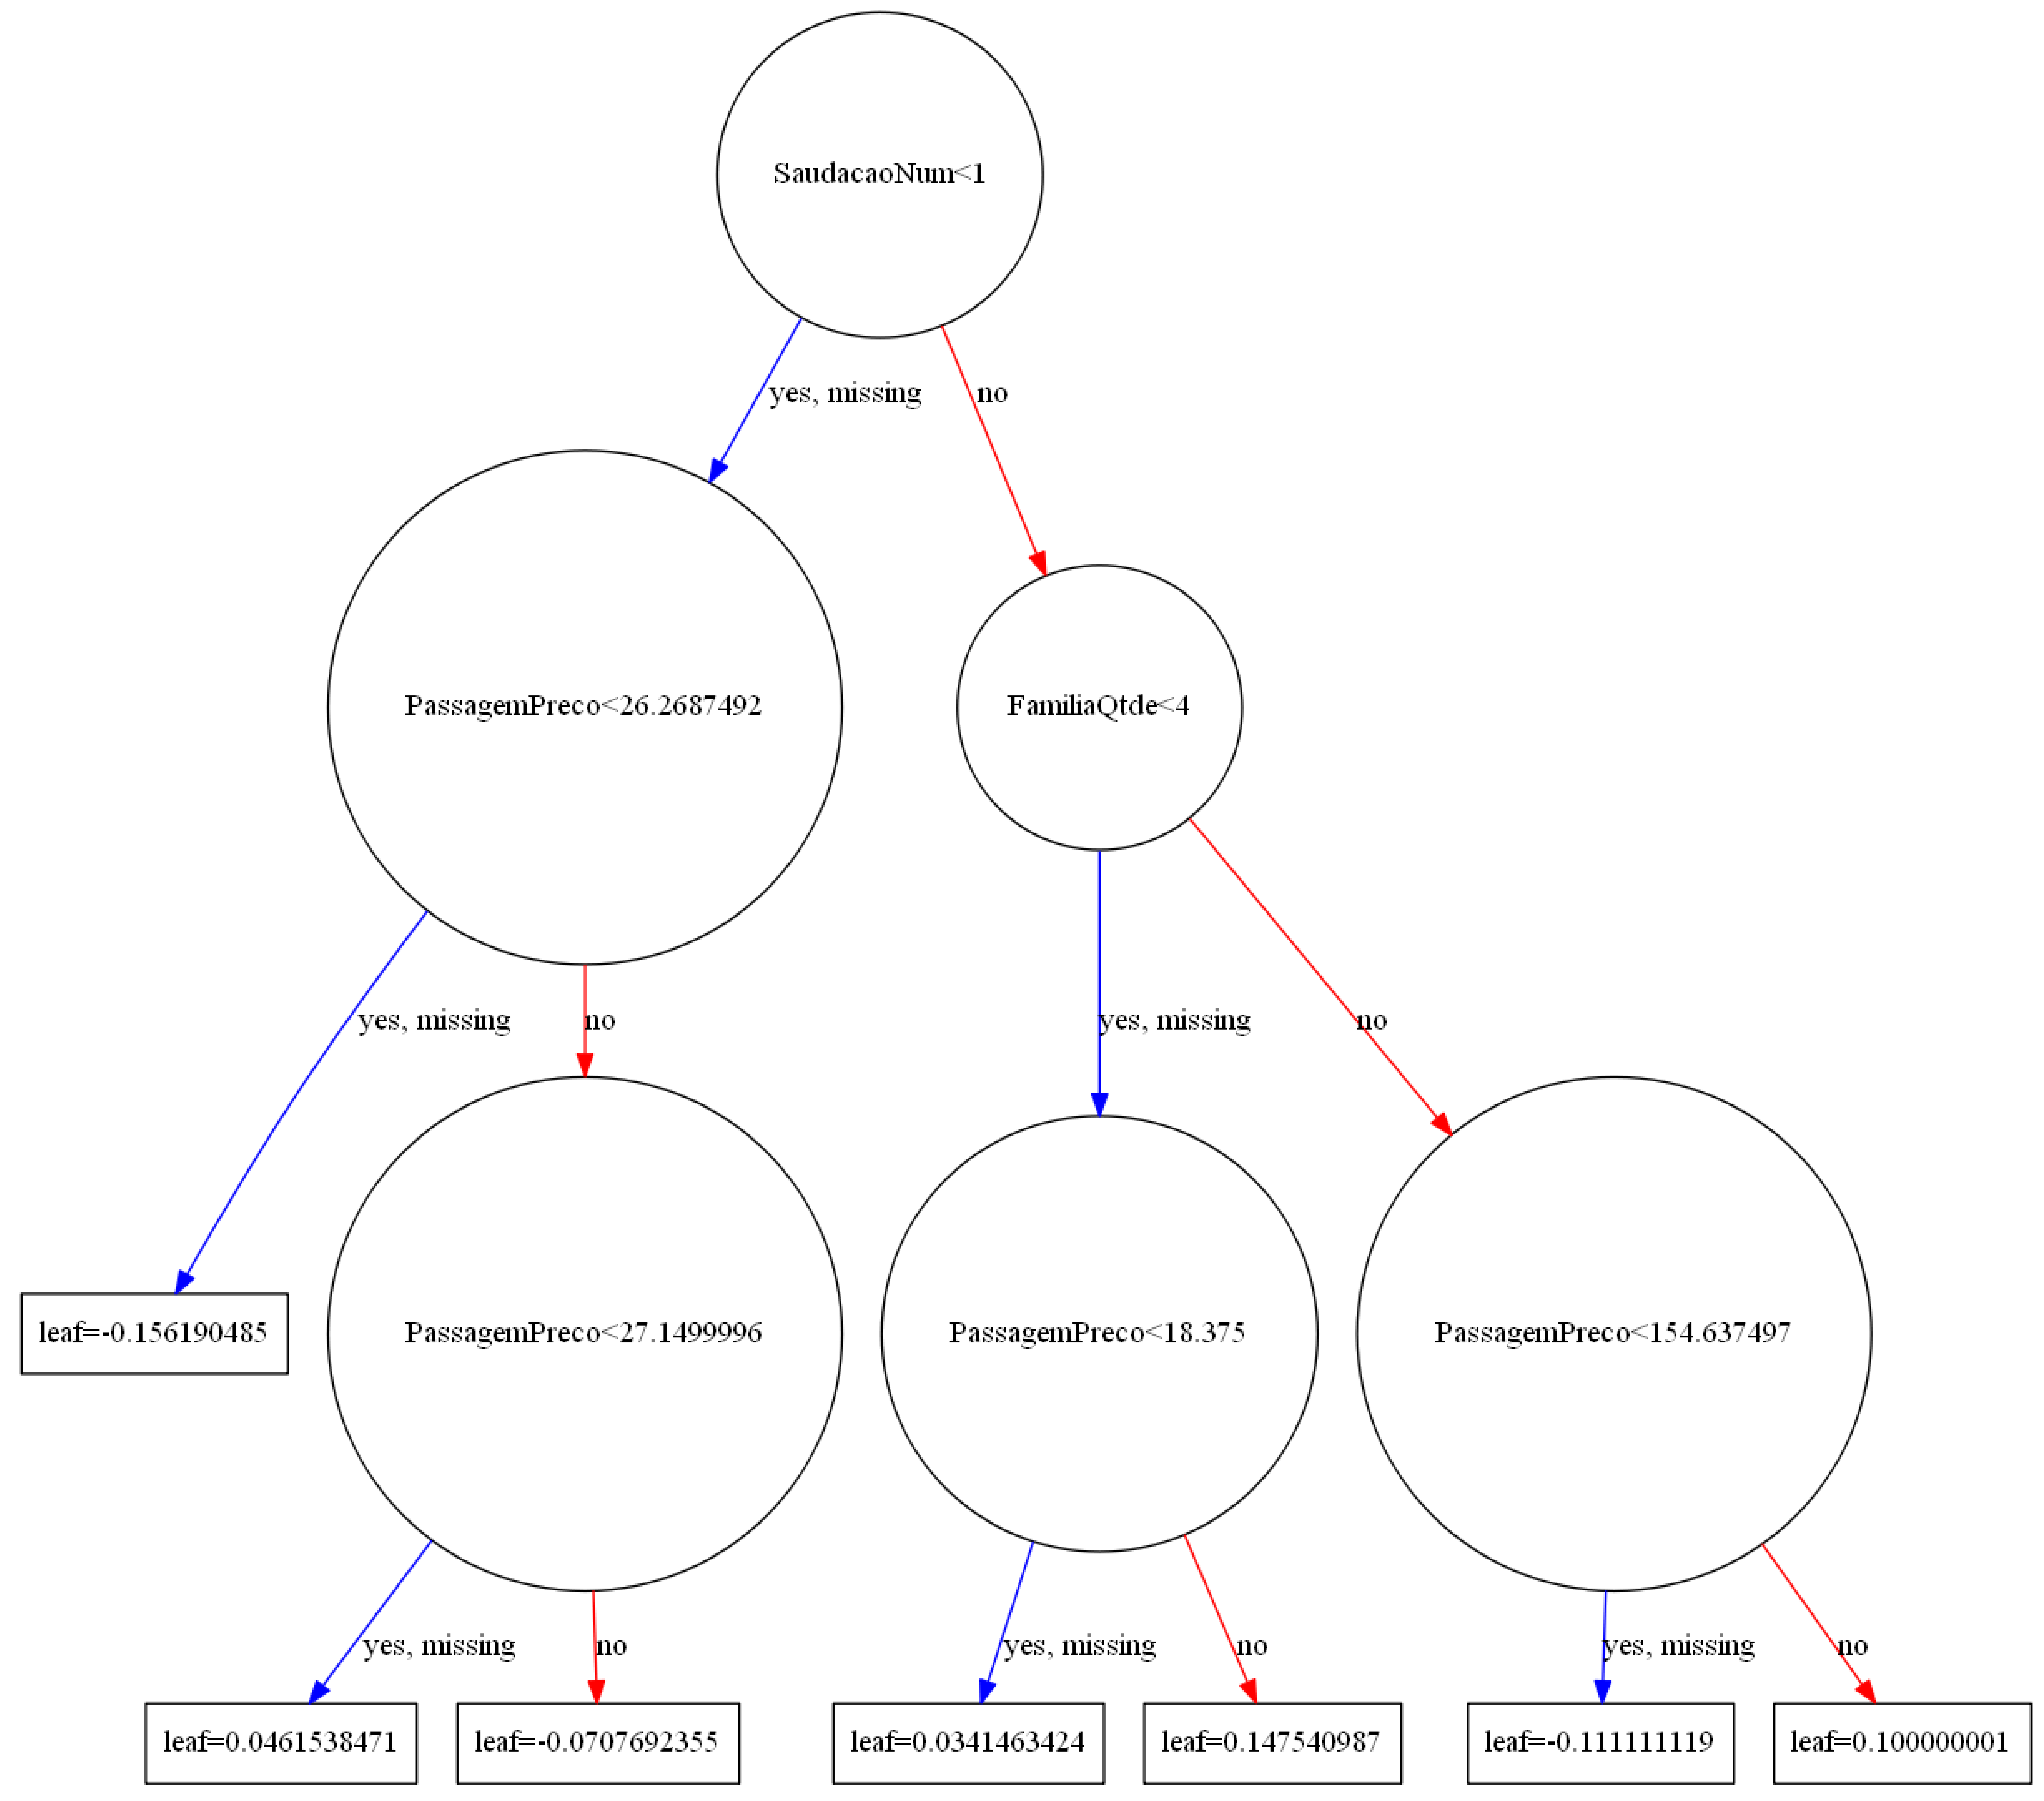

In [26]:
xgb.plot_tree(xgb_model)
fig = pl.gcf()
fig.set_size_inches(150, 100)